In [87]:
import pandas_profiling
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.subplots as sbl
from sklearn.tree import export_graphviz
import graphviz

from sklearn.preprocessing import (LabelEncoder, StandardScaler)
from scipy.stats import ttest_ind
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, log_loss, classification_report, confusion_matrix, 
precision_score, roc_auc_score, recall_score, roc_curve, precision_recall_curve)


In [23]:
employees = pd.read_csv('HR-Attrition-upsampled-cleaned.csv')
employees.shape

(2466, 21)

In [24]:
employees.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,...,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany
0,49,No,Travel_Frequently,Research & Development,8,1,Life Sciences,3,Male,2,...,Married,5130,1,No,23,4,1,3,3,10
1,33,No,Travel_Frequently,Research & Development,3,4,Life Sciences,4,Female,3,...,Married,2909,1,Yes,11,3,0,3,3,8
2,27,No,Travel_Rarely,Research & Development,2,1,Medical,1,Male,3,...,Married,3468,9,No,12,4,1,3,3,2
3,32,No,Travel_Frequently,Research & Development,2,2,Life Sciences,4,Male,3,...,Single,3068,0,No,13,3,0,2,2,7
4,59,No,Travel_Rarely,Research & Development,3,3,Medical,3,Female,4,...,Married,2670,4,Yes,20,1,3,3,2,1


# EDA

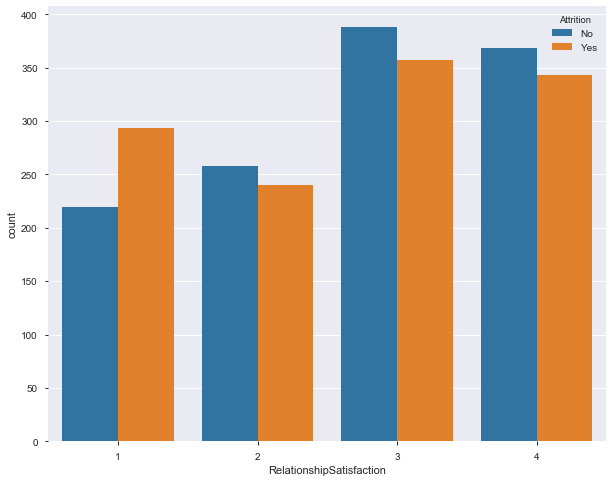

In [25]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x="RelationshipSatisfaction", hue='Attrition', data=employees)

People with low relationship satisfaction have high attrition.

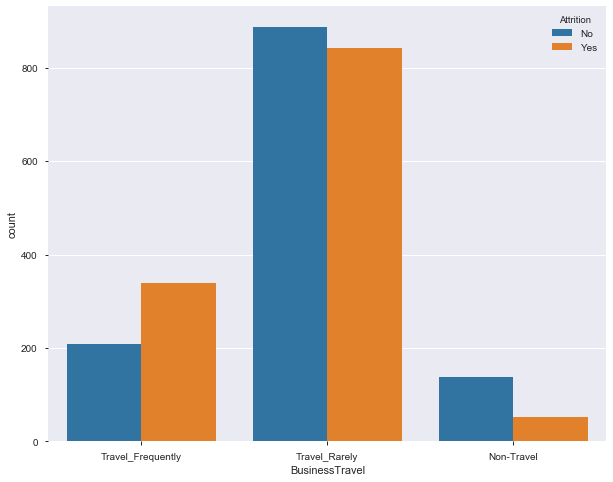

In [26]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x="BusinessTravel", hue='Attrition', data=employees)

Employees who travel more frequently are more likely to attrite.

In [33]:
# Let's do a t-test to check the job involvement average for employees who will leave and those who stay
employees.groupby(['JobInvolvement', 'Attrition'])['Attrition'].agg('count')


leave = employees[employees['Attrition']=='Yes']
stay = employees[employees['Attrition']=='No']

print("Average job involevemtn rating for employees who leave: " + str(leave['JobInvolvement'].mean()))
print("Average job involevemtn rating for employees who stay: " + str(stay['JobInvolvement'].mean()))

ttest_ind(leave['JobInvolvement'], stay['JobInvolvement'])

Average job involevemtn rating for employees who leave: 2.5255474452554743
Average job involevemtn rating for employees who stay: 2.770478507704785


Ttest_indResult(statistic=-8.380667996408349, pvalue=8.721810959875347e-17)

Employees who stay have high job involvement rating and the difference is statistically significant.

# Variable transformation

In [35]:
def transform(row):
    if row['PercentSalaryHike'] < 15:
        val = 'Yes'
    else:
        val = 'No'
    return val

employees['low_percentage_hike'] = employees.apply(transform, axis=1)
employees = employees.drop('PercentSalaryHike', axis=1)

In [36]:
def transform_relation_sat(row):
    if row['RelationshipSatisfaction'] == 1:
        val = 'Yes'
    else:
        val = 'No'
    return val

employees['low_relationship_satisfaction'] = employees.apply(transform_relation_sat, axis=1)
employees = employees.drop('RelationshipSatisfaction', axis=1)

In [37]:
def transform_business_travel(row):
    if row['BusinessTravel'] == 'Travel_Frequently':
        val = 'Yes'
    else:
        val = 'No'
    return val

employees['frequent_travel'] = employees.apply(transform_business_travel, axis=1)
employees = employees.drop('BusinessTravel', axis=1)

In [38]:
def transform_job_involve(row):
    if row['JobInvolvement'] == 1:
        val = 'Yes'
    else:
        val = 'No'
    return val

employees['low_job_involvement'] = employees.apply(transform_job_involve, axis=1)
employees = employees.drop('JobInvolvement', axis=1)

In [39]:
def transform_wl_balance(row):
    if row['WorkLifeBalance'] == 1:
        val = 'Yes'
    else:
        val = 'No'
    return val

employees['low_worklife_balance'] = employees.apply(transform_wl_balance, axis=1)
employees = employees.drop('WorkLifeBalance', axis=1)

In [40]:
employees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 21 columns):
Age                              2466 non-null int64
Attrition                        2466 non-null object
Department                       2466 non-null object
DistanceFromHome                 2466 non-null int64
Education                        2466 non-null int64
EducationField                   2466 non-null object
EnvironmentSatisfaction          2466 non-null int64
Gender                           2466 non-null object
JobSatisfaction                  2466 non-null int64
MaritalStatus                    2466 non-null object
MonthlyIncome                    2466 non-null int64
NumCompaniesWorked               2466 non-null int64
OverTime                         2466 non-null object
StockOptionLevel                 2466 non-null int64
TrainingTimesLastYear            2466 non-null int64
YearsAtCompany                   2466 non-null int64
low_percentage_hike              2466 n

In [41]:
df_num = employees[['Age', 'DistanceFromHome', 'MonthlyIncome', 'NumCompaniesWorked', 
                    'TrainingTimesLastYear', 'YearsAtCompany']]
df_num.columns

Index(['Age', 'DistanceFromHome', 'MonthlyIncome', 'NumCompaniesWorked',
       'TrainingTimesLastYear', 'YearsAtCompany'],
      dtype='object')

In [42]:
categorical = [col for col in employees.columns if col not in df_num.columns]

attrition_cat = employees[categorical]
attrition_cat = attrition_cat.drop(['Attrition'], axis=1)
attrition_cat.head()

,Department,Education,EducationField,EnvironmentSatisfaction,Gender,JobSatisfaction,MaritalStatus,OverTime,StockOptionLevel,low_percentage_hike,low_relationship_satisfaction,frequent_travel,low_job_involvement,low_worklife_balance
0,Research & Development,1,Life Sciences,3,Male,2,Married,No,1,No,No,Yes,No,No
1,Research & Development,4,Life Sciences,4,Female,3,Married,Yes,0,Yes,No,Yes,No,No
2,Research & Development,1,Medical,1,Male,2,Married,No,1,Yes,No,No,No,No
3,Research & Development,2,Life Sciences,4,Male,4,Single,No,0,Yes,No,Yes,No,No
4,Research & Development,3,Medical,3,Female,1,Married,Yes,3,No,Yes,No,No,No


Label encoding for categorical variables

In [43]:
labelencoder = LabelEncoder()

attrition_cat['Department'] = labelencoder.fit_transform(attrition_cat['Department'])
attrition_cat['EducationField'] = labelencoder.fit_transform(attrition_cat['EducationField'])
attrition_cat['Gender'] = labelencoder.fit_transform(attrition_cat['Gender'])
attrition_cat['MaritalStatus'] = labelencoder.fit_transform(attrition_cat['MaritalStatus'])
attrition_cat['OverTime'] = labelencoder.fit_transform(attrition_cat['OverTime'])
attrition_cat['low_percentage_hike'] = labelencoder.fit_transform(attrition_cat['low_percentage_hike'])
attrition_cat['low_relationship_satisfaction'] = labelencoder.fit_transform(attrition_cat['low_relationship_satisfaction'])
attrition_cat['frequent_travel'] = labelencoder.fit_transform(attrition_cat['frequent_travel'])
attrition_cat['low_job_involvement'] = labelencoder.fit_transform(attrition_cat['low_job_involvement'])
attrition_cat['low_worklife_balance'] = labelencoder.fit_transform(attrition_cat['low_worklife_balance'])

attrition_cat.head()

,Department,Education,EducationField,EnvironmentSatisfaction,Gender,JobSatisfaction,MaritalStatus,OverTime,StockOptionLevel,low_percentage_hike,low_relationship_satisfaction,frequent_travel,low_job_involvement,low_worklife_balance
0,1,1,1,3,1,2,1,0,1,0,0,1,0,0
1,1,4,1,4,0,3,1,1,0,1,0,1,0,0
2,1,1,3,1,1,2,1,0,1,1,0,0,0,0
3,1,2,1,4,1,4,2,0,0,1,0,1,0,0
4,1,3,3,3,0,1,1,1,3,0,1,0,0,0


In [44]:
for col in attrition_cat.columns:
    
    if attrition_cat[col].dtypes==int:
        attrition_cat[col] = attrition_cat[col].astype('category')
    print(str(col)+ ": " + str(attrition_cat[col].dtypes))

Department: category
Education: category
EducationField: category
EnvironmentSatisfaction: category
Gender: category
JobSatisfaction: category
MaritalStatus: category
OverTime: category
StockOptionLevel: category
low_percentage_hike: category
low_relationship_satisfaction: category
frequent_travel: category
low_job_involvement: category
low_worklife_balance: category


In [45]:
attrition_cat_dummy = pd.get_dummies(attrition_cat) # creating dummy variables for categorical variables
attrition_cat_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 43 columns):
Department_0                       2466 non-null uint8
Department_1                       2466 non-null uint8
Department_2                       2466 non-null uint8
Education_1                        2466 non-null uint8
Education_2                        2466 non-null uint8
Education_3                        2466 non-null uint8
Education_4                        2466 non-null uint8
Education_5                        2466 non-null uint8
EducationField_0                   2466 non-null uint8
EducationField_1                   2466 non-null uint8
EducationField_2                   2466 non-null uint8
EducationField_3                   2466 non-null uint8
EducationField_4                   2466 non-null uint8
EducationField_5                   2466 non-null uint8
EnvironmentSatisfaction_1          2466 non-null uint8
EnvironmentSatisfaction_2          2466 non-null uint8
EnvironmentSa

In [47]:
scaled_features = StandardScaler().fit_transform(df_num.values) # scaling the features
scaled_features

array([[ 1.42370004, -0.20901457, -0.16131462, -0.68976239,  0.19849996,
         0.58668886],
       [-0.2588468 , -0.8124212 , -0.66234239, -0.68976239,  0.19849996,
         0.26822645],
       [-0.88980187, -0.93310252, -0.5362395 ,  2.37778323,  0.19849996,
        -0.68716078],
       ...,
       [-0.99496104,  0.87711735, -0.70024093, -1.07320559, -0.59101762,
         0.10899524],
       [-0.04852844,  0.51507338, -0.47420319, -0.68976239, -0.59101762,
        -0.36869837],
       [-1.83623447, -0.8124212 , -0.96462839, -0.68976239, -0.59101762,
        -1.00562318]])

In [48]:
scaled_features_df_num = pd.DataFrame(scaled_features, index=df_num.index, columns=df_num.columns)
scaled_features_df_num.head()

,Age,DistanceFromHome,MonthlyIncome,NumCompaniesWorked,TrainingTimesLastYear,YearsAtCompany
0,1.423700,-0.209015,-0.161315,-0.689762,0.198500,0.586689
1,-0.258847,-0.812421,-0.662342,-0.689762,0.198500,0.268226
2,-0.889802,-0.933103,-0.536239,2.377783,0.198500,-0.687161
3,-0.364006,-0.933103,-0.626474,-1.073206,-0.591018,0.108995
4,2.475292,-0.812421,-0.716258,0.460567,0.198500,-0.846392


In [49]:
attrition_final = pd.concat([scaled_features_df_num, attrition_cat_dummy], axis=1)
print("Shape of final dataset attrition_final: " + str(attrition_final.shape))
attrition_final.head()

Shape of final dataset attrition_final: (2466, 49)


,Age,DistanceFromHome,MonthlyIncome,NumCompaniesWorked,TrainingTimesLastYear,YearsAtCompany,Department_0,Department_1,Department_2,Education_1,...,low_percentage_hike_0,low_percentage_hike_1,low_relationship_satisfaction_0,low_relationship_satisfaction_1,frequent_travel_0,frequent_travel_1,low_job_involvement_0,low_job_involvement_1,low_worklife_balance_0,low_worklife_balance_1
0,1.423700,-0.209015,-0.161315,-0.689762,0.198500,0.586689,0,1,0,1,...,1,0,1,0,0,1,1,0,1,0
1,-0.258847,-0.812421,-0.662342,-0.689762,0.198500,0.268226,0,1,0,0,...,0,1,1,0,0,1,1,0,1,0
2,-0.889802,-0.933103,-0.536239,2.377783,0.198500,-0.687161,0,1,0,1,...,0,1,1,0,1,0,1,0,1,0
3,-0.364006,-0.933103,-0.626474,-1.073206,-0.591018,0.108995,0,1,0,0,...,0,1,1,0,0,1,1,0,1,0
4,2.475292,-0.812421,-0.716258,0.460567,0.198500,-0.846392,0,1,0,0,...,1,0,0,1,1,0,1,0,1,0


In [50]:
# Define a dictionary for the target mapping
target_map = {'Yes':1, 'No':0}
# Use the pandas apply method to numerically encode our attrition target variable
target = employees["Attrition"].apply(lambda x: target_map[x])
target.value_counts()

1    1233
0    1233
Name: Attrition, dtype: int64

In [51]:
import plotly.figure_factory as ff

def model_performance_plot(model) : 
    #conf matrix
    conf_matrix = confusion_matrix(target_val, y_pred)
#     trace1 = go.Heatmap(z=conf_matrix  ,x = ["No (pred)","Yes (pred)"],
#                         y = ["No (Actual)","Yes (Actual)"], xgap=2, ygap=2,
#                         colorscale = 'Viridis', 
#                         showscale=False, text=conf_matrix)
#     trace1 = ff.create_annotated_heatmap(conf_matrix, annotation_text=conf_matrix, 
#                                          colorscale=colorscale, hoverinfo='z')
#     for i in range(len(trace1.layout.annotations)):
#         trace1.layout.annotations[i].font.size = 9

    #show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                   y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto',
                   orientation = 'h', opacity = 0.8,marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    #plot roc curve
    model_roc_auc = round(roc_auc_score(target_val, y_score) , 3)
    fpr, tpr, t = roc_curve(target_val, y_score)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : ",
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(target_val, y_score)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
    #subplots
    fig = sbl.make_subplots(rows=3, cols=1, print_grid=False, 
                        subplot_titles=('Metrics',
                                        'ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                        'Precision - Recall curve'))
    

    fig.append_trace(trace2,1,1)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,3,1)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance</b><br>'+str(model),
                        autosize = False, height = 900,width = 450,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        margin = dict(b = 195))
#     fig["layout"]["xaxis2"].update((dict(range=[0, 1])))
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis3"].update(dict(title = "recall"), range = [0,1.05])
    fig["layout"]["yaxis3"].update(dict(title = "precision"), range = [0,1.05])
    fig.layout.titlefont.size = 14
    
    py.iplot(fig)

In [78]:
def plot_feature_importance(model):
    tmp = pd.DataFrame({'Feature': list(attrition_final_tree), 'Feature importance': model.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance',ascending=False).head(12)
    plt.figure(figsize = (8,8))
    plt.title('Top 12 - Features importance - {0}'.format(str(model).split('(')[0]),fontsize=14)
    s = sns.barplot(y='Feature',x='Feature importance',data=tmp, orient='h')
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()

In [71]:
def plot_confusion_matrix(model):
    conf_matrix = confusion_matrix(target_val, y_pred)
    trace1 = go.Heatmap(z=conf_matrix  ,x = ["No (pred)","Yes (pred)"],
                        y = ["No (Actual)","Yes (Actual)"], xgap=2, ygap=2,
                        colorscale = 'Viridis', 
                        showscale=False, text=conf_matrix)
    trace1 = ff.create_annotated_heatmap(conf_matrix, x = ["No (pred)","Yes (pred)"],
                        y = ["No (Actual)","Yes (Actual)"], xgap=2, ygap=2,
                        colorscale = 'Viridis', 
                        showscale=False, annotation_text=conf_matrix, 
                                         hoverinfo='z')
    trace1['layout'].update(showlegend = False, title = '<b>Model Confusion matrix</b><br>'+str(model).split('(')[0],
                        autosize = True, height = 450,width = 410,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        margin = dict(b = 195))
    # for i in range(len(trace1.layout.annotations)):
    #     trace1.layout.annotations[i].font.size = 9

    trace1.show()

# Classification

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

attrition_final_tree = pd.concat([scaled_features_df_num, attrition_cat], axis=1)
# Split data into train and test sets
train, test, target_train, target_val = train_test_split(attrition_final_tree, 
                                                         target, 
                                                         train_size= 0.80, random_state=0)

## Random forest

In [58]:
from sklearn.ensemble import RandomForestClassifier

seed = 345
# Random Forest parameters
rf_params = {
    'criterion': 'entropy',
    'n_jobs': -1,
    'n_estimators': 100,
#     'warm_start': True, 
    'max_features': 0.3,
    'max_depth': 4,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'random_state' : seed,
    'verbose': 0
}

rf = RandomForestClassifier(**rf_params)
# rf = RandomForestClassifier()
rf.fit(train, target_train)
print("Fitting of Random Forest finished")

Fitting of Random Forest finished


In [59]:
rf_predictions = rf.predict(test)
print("Predictions finished")

Predictions finished


In [61]:
print("Accuracy score: {}".format(accuracy_score(target_val, rf_predictions)))
print("="*80)
print(classification_report(target_val, rf_predictions))

Accuracy score: 0.7813765182186235
              precision    recall  f1-score   support

           0       0.77      0.80      0.79       250
           1       0.79      0.76      0.77       244

    accuracy                           0.78       494
   macro avg       0.78      0.78      0.78       494
weighted avg       0.78      0.78      0.78       494



In [62]:
y_pred = rf.predict(test)
y_score = rf.predict_proba(test)[:,1]

model_performance_plot('rf')

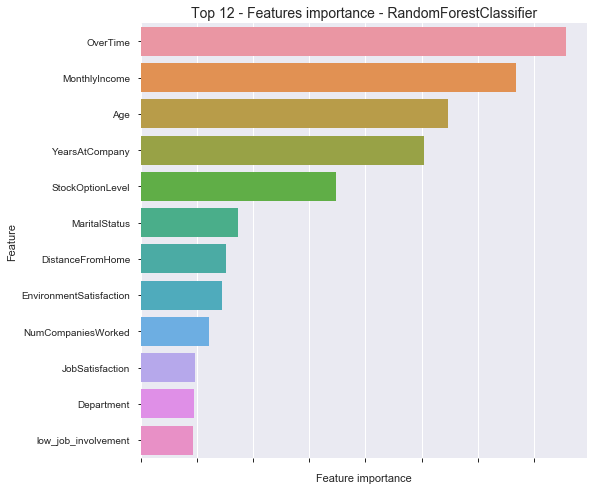

In [79]:
plot_feature_importance(rf)
plot_confusion_matrix(rf)

## Gradient boosting

In [82]:
# Gradient Boosting Parameters
gb_params ={
    'n_estimators': 1500,
    'max_features': 0.9,
    'learning_rate' : 0.25,
    'max_depth': 4,
    'min_samples_leaf': 2,
    'subsample': 1,
    'max_features' : 'sqrt',
    'random_state' : seed,
    'verbose': 0
}

gb = GradientBoostingClassifier(**gb_params)
# Fit the model to our SMOTEd train and target
gb.fit(train, target_train)
# Get our predictions
gb_predictions = gb.predict(test)
print("Predictions have finished")

Predictions have finished


In [83]:
print(accuracy_score(target_val, gb_predictions))
print(classification_report(target_val, gb_predictions))

0.9595141700404858
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       250
           1       0.92      1.00      0.96       244

    accuracy                           0.96       494
   macro avg       0.96      0.96      0.96       494
weighted avg       0.96      0.96      0.96       494



In [84]:
y_pred = gb.predict(test)
y_score = gb.predict_proba(test)[:,1]

model_performance_plot('gb')

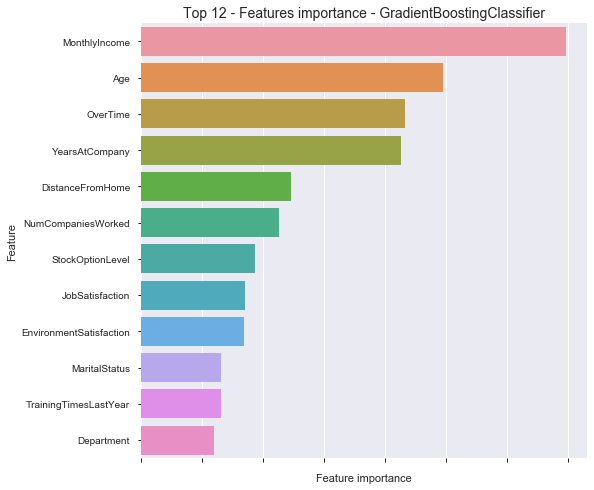

In [85]:
plot_feature_importance(gb)

## Decision Tree

In [86]:
tree_params = {
    'criterion': 'entropy',
    'max_depth': 4,
    'min_samples_leaf': 2,
    'min_samples_split': 10,
    'random_state': 123
}
tree_clf = tree.DecisionTreeClassifier(**tree_params)

tree_clf.fit(train, target_train)

dec_tree_predictions = tree_clf.predict(test)
print("Predictions finished")

Predictions finished


In [99]:
print(accuracy_score(target_val, dec_tree_predictions))
print(classification_report(target_val, dec_tree_predictions))

0.7327935222672065
              precision    recall  f1-score   support

           0       0.70      0.82      0.76       250
           1       0.78      0.64      0.70       244

    accuracy                           0.73       494
   macro avg       0.74      0.73      0.73       494
weighted avg       0.74      0.73      0.73       494



In [100]:
from sklearn.tree import export_graphviz

export_graphviz(tree_clf, out_file="decision_tree_orig_final.dot", max_depth=4,feature_names=train.columns, class_names=['0','1'], impurity=False, filled=True)


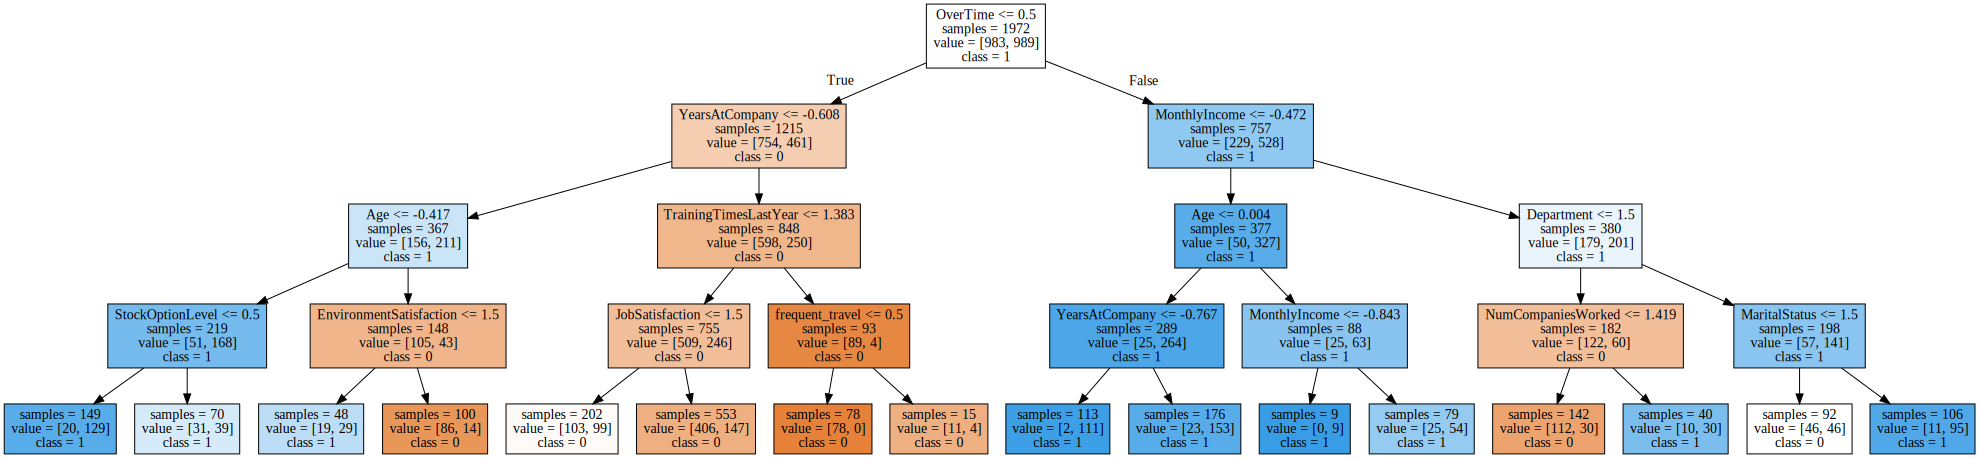

In [101]:
import graphviz
with open("decision_tree_orig_final.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [88]:
y_pred = tree_clf.predict(test)
y_score = tree_clf.predict_proba(test)[:,1]

model_performance_plot('tree_clf')

### From the feature importance graph of gbm and decision tree graph, it can be observed that Overtime is the most important feature in determining if an employee will leave or not. Years at company and monthly income are also among top features.